<a href="https://colab.research.google.com/github/Jinke233/work/blob/master/tutorials/zero-shot/Tutorial_ZeroShot_Integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zero-shot integration tutorial with scGPT

## Introduction

This tutorial covers the zero-shot integration with scGPT. This particular workflow works for scRNA-seq datasets without fine-tuning (or any extensive training) of scGPT.


We will use the Lung-Kim dataset as an example. The dataset comprises 14 primary human lung adenocarcinoma samples and 32,493 cells. This dataset is publicly accessible via the [Curated Cancer Cell Atlas](https://www.weizmann.ac.il/sites/3CA/lung), which can be downloaded from [here](https://drive.google.com/file/d/1z_0vWYMhRuRiD1EyhuFtY9ReIR0msWaL/view?usp=sharing). You may place the dataset under `data` directory at the outer level.

For scGPT model weight, we use the `scGPT_human` model to provide embeddings out of the box. You may download it from [here](https://drive.google.com/drive/folders/1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y).


The zero-shot integration workflow is as follows:

 1. [Load and pre-process the dataset](#prepare-the-datasets)
    
 2. [Generate scGPT embeddings for each cell](#generate-the-cell-embeddings)

At the [appendix](#appendix-zero-shot-integration-on-covid-19-dataset-and-ms-dataset) of this tutorial notebook, we will also showcase the zero-shot integration performance on COVID-19 dataset and Multiple Sclerosis (M.S.) dataset, you can find and download the datasets here: [COVID-19](https://drive.google.com/file/d/1eD9LbxNJ35YUde3VtdVcjkwm-f4iyJ6x/view?usp=drive_link) and [MS](https://drive.google.com/drive/folders/1Qd42YNabzyr2pWt9xoY4cVMTAxsNBt4v?usp=sharing)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bowang-lab/scGPT/blob/main/tutorials/zero-shot/Tutorial_ZeroShot_Integration.ipynb)

In [4]:
pip uninstall torchvision


Found existing installation: torchvision 0.16.2
Uninstalling torchvision-0.16.2:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/torchvision-0.16.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libcudart.7ec1eba6.so.12
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libjpeg.ceea7512.so.62
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libnvjpeg.f00ca762.so.12
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libpng16.7f72a3c5.so.16
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libz.0ba23de2.so.1
    /usr/local/lib/python3.10/dist-packages/torchvision/*
Proceed (Y/n)? n


In [2]:
# Specifically for Google Colab, install dependencies and download data

import os
import sys

if "google.colab" in sys.modules:
    print("Running on Google Colab")
    print("Installing dependencies...")
    !pip install -U scgpt
    # the optional dependency of flash-attion is skipped on colab
    !pip install wandb louvain

    # NOTE: May need to restart runtime after the installation

    print("Downloading data and model ckpt...")
    !pip install -q -U gdown
    import gdown

    data_dir = "../../data"
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)
    if not os.path.exists(os.path.join(data_dir, "Kim2020_Lung.h5ad")):
        !gdown https://drive.google.com/uc?id=1z_0vWYMhRuRiD1EyhuFtY9ReIR0msWaL -O $data_dir/
    if not os.path.exists(os.path.join(data_dir, "covid_subsampled.h5ad")):
        !gdown https://drive.google.com/uc?id=1eD9LbxNJ35YUde3VtdVcjkwm-f4iyJ6x -O $data_dir/
    if not os.path.exists(os.path.join(data_dir, "ms")):
        gdown.download_folder(
            "https://drive.google.com/drive/folders/1Qd42YNabzyr2pWt9xoY4cVMTAxsNBt4v",
            output=os.path.join(data_dir, "ms"),
        )

    print("Downloading model ckpt...")
    model_dir = "../../save/scGPT_human"
    if not os.path.exists(model_dir):
        !mkdir -p $model_dir
        gdown.download_folder(
            "https://drive.google.com/drive/folders/1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y",
            output=model_dir,
        )

Running on Google Colab
Installing dependencies...


## Import scGPT and dependencies

In [3]:
from pathlib import Path
import warnings

import scanpy as sc
import scib
import numpy as np
import sys

sys.path.insert(0, "../")

import scgpt as scg
import matplotlib.pyplot as plt
import anndata

plt.style.context('default')
warnings.simplefilter("ignore", ResourceWarning)

model_dir = Path("../../save/scGPT_human")

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/dist-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn i

## Set up evaluation function

We set up the evaluation function, we mainly compare the integration performance on avgBIO and avgBATCH. Refer to our manuscript for more details.

In [5]:
"""
Calculate the metrics for integration results
"""
def scib_eval(adata, batch_key, cell_type_key, embed_key):
    results = scib.metrics.metrics(
        adata,
        adata_int=adata,
        batch_key=batch_key,
        label_key=cell_type_key,
        embed=embed_key,
        isolated_labels_asw_=False,
        silhouette_=True,
        hvg_score_=False,
        graph_conn_=True,
        pcr_=True,
        isolated_labels_f1_=False,
        trajectory_=False,
        nmi_=True,  # use the clustering, bias to the best matching
        ari_=True,  # use the clustering, bias to the best matching
        cell_cycle_=False,
        kBET_=False,  # kBET return nan sometimes, need to examine
        ilisi_=False,
        clisi_=False,
    )
    result_dict = results[0].to_dict()

    # compute avgBIO metrics
    result_dict["avg_bio"] = np.mean(
        [
            result_dict["NMI_cluster/label"],
            result_dict["ARI_cluster/label"],
            result_dict["ASW_label"],
        ]
    )

    # compute avgBATCH metrics
    result_dict["avg_batch"] = np.mean(
        [
            result_dict["graph_conn"],
            result_dict["ASW_label/batch"],
        ]
    )

    result_dict = {k: v for k, v in result_dict.items() if not np.isnan(v)}

    return result_dict

## Prepare the datasets

Load the Lung-kim dataset (download it from [here](https://drive.google.com/file/d/1z_0vWYMhRuRiD1EyhuFtY9ReIR0msWaL/view?usp=sharing)), and we set the columns storing gene name columns, batch key and cell type key (optional, this is for evaluation).

In [6]:
smaple_data_path = '../../data/Kim2020_Lung.h5ad'
adata = sc.read_h5ad(smaple_data_path)

gene_col = "gene_name"
cell_type_key = "cell_type"
batch_key = "sample"
N_HVG = 3000

Remove unannotated cells:

In [7]:
celltype_id_labels = adata.obs[cell_type_key].astype("category").cat.codes.values
adata = adata[celltype_id_labels >= 0]

Make a copy of the dataset

In [8]:
org_adata = adata.copy()

Preprocess the dataset and select `N_HVG` highly variable genes for downstream analysis.

In [9]:
# highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=N_HVG, flavor='seurat_v3')
adata = adata[:, adata.var['highly_variable']]

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

## Generate the cell embeddings

Now we will generate the cell embeddings for the dataset using `embed_data` function. `embed_data` calculates the cell embedding for each cell with the given scGPT model. The extracted embedding is stored in the `X_scGPT` field of `obsm` in AnnData.

In [10]:
embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)
# attach the cell embedding to the original adata

/usr/local/lib/python3.10/dist-packages/scgpt/tasks/cell_emb.py:212: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["id_in_vocab"] = [


scGPT - INFO - match 2978/3000 genes in vocabulary of size 60697.


/usr/local/lib/python3.10/dist-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module(

## Visualize the integration performance

UMAP of scGPT embedding colored by cell type:

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

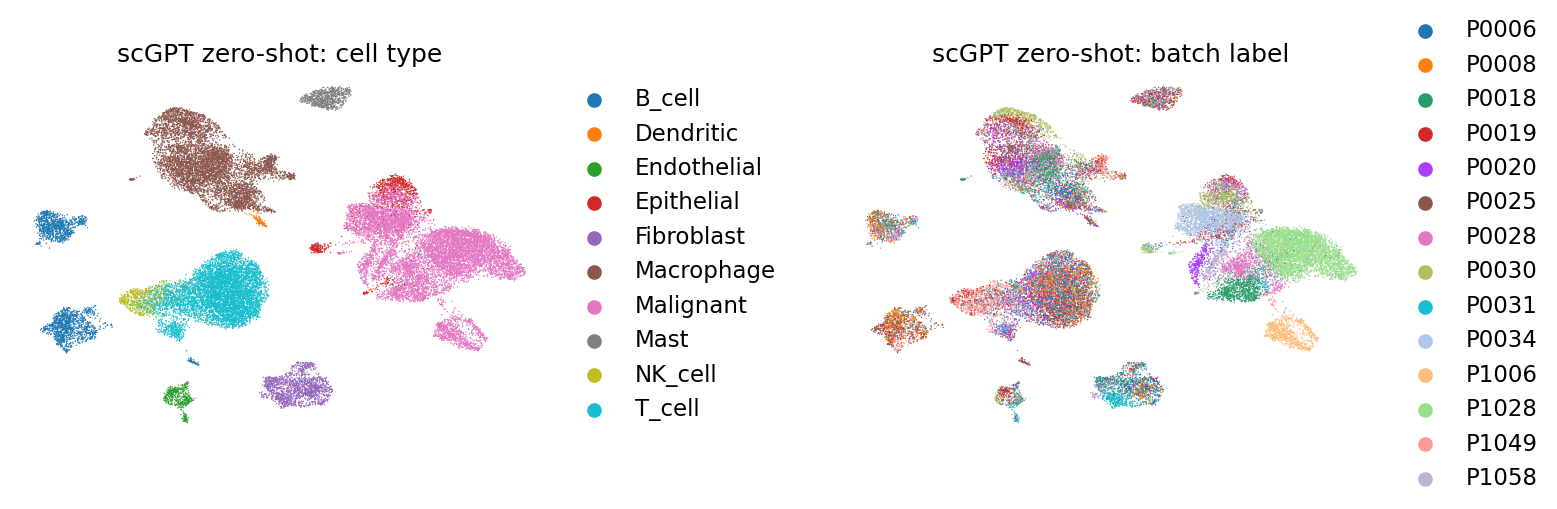

In [11]:
sc.pp.neighbors(embed_adata, use_rep="X_scGPT")
sc.tl.umap(embed_adata)
sc.pl.umap(embed_adata,
           color=[cell_type_key, batch_key],
           frameon=False,
           wspace=0.4,
           title=["scGPT zero-shot: cell type", "scGPT zero-shot: batch label"])

## Evaluate the integration performance

In [12]:
scib_result_dict = scib_eval(
    embed_adata,
    batch_key=batch_key,
    cell_type_key=cell_type_key,
    embed_key="X_scGPT",
)

/usr/local/lib/python3.10/dist-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


PC regression...


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Variance contribution increased after integration!
Setting PCR comparison score to 0.
Graph connectivity...


/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.1

In [ ]:
print("AvgBIO: {:.4f}".format(scib_result_dict["avg_bio"]))
print("AvgBATCH: {:.4f}".format(scib_result_dict["avg_batch"]))

AvgBIO: 0.7752
AvgBATCH: 0.9500


## Comparison with HVG+PCs

We compute the HVG and PCs based on the dataset, this will serve as a baseline for the integration performance.

In [13]:
adata = org_adata.copy()
sc.pp.highly_variable_genes(adata, n_top_genes=N_HVG, flavor='seurat_v3')
adata = adata[:, adata.var['highly_variable']]
sc.pp.pca(adata, n_comps=40)
sc.pp.neighbors(adata, use_rep="X_pca")

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


UMAP of PCs colored by cell types and batch labels:

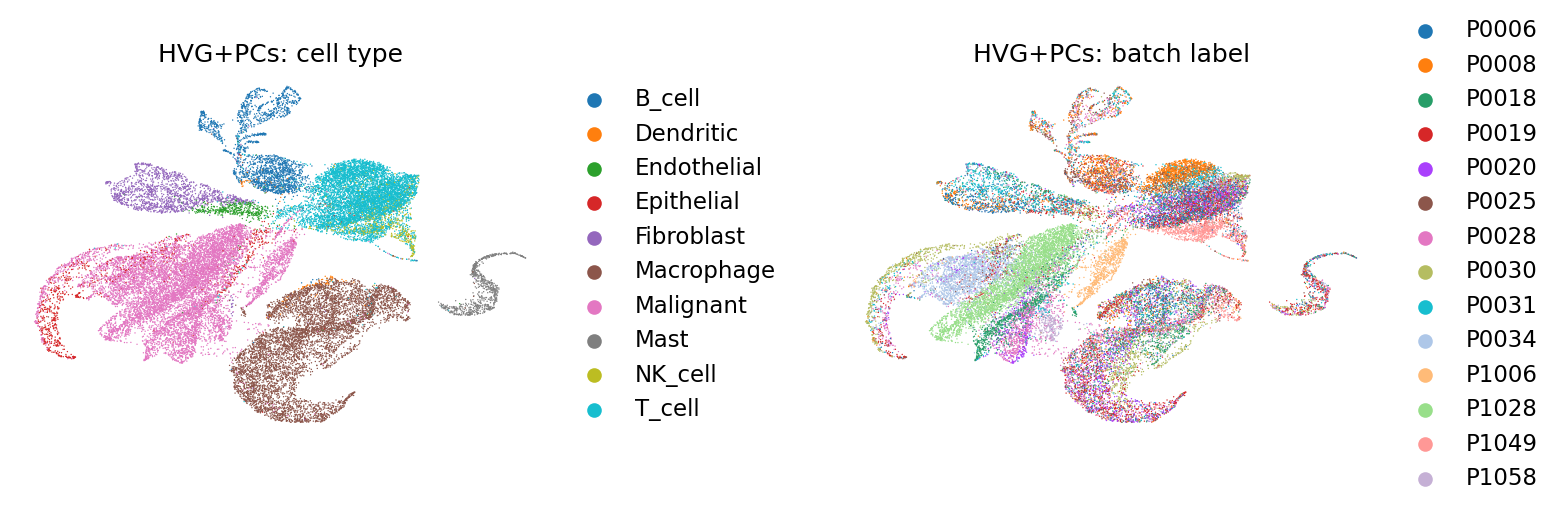

In [14]:
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)
sc.pl.umap(adata,
           color=[cell_type_key, batch_key],
           frameon=False,
           wspace=0.4,
           title=["HVG+PCs: cell type", "HVG+PCs: batch label"])

In [15]:
scib_result_dict = scib_eval(
    adata,
    batch_key=batch_key,
    cell_type_key=cell_type_key,
    embed_key="X_pca",
)

/usr/local/lib/python3.10/dist-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Graph connectivity...


/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.1

In [16]:
print("AvgBIO: {:.4f}".format(scib_result_dict["avg_bio"]))
print("AvgBATCH: {:.4f}".format(scib_result_dict["avg_batch"]))

AvgBIO: 0.6663
AvgBATCH: 0.8082


## Appendix: Zero-shot integration on COVID-19 dataset and MS dataset

### COVID-19 dataset

The dataset can be accessed form [here](https://drive.google.com/file/d/1eD9LbxNJ35YUde3VtdVcjkwm-f4iyJ6x/view?usp=drive_link).

In [17]:
# load dataset
adata = sc.read_h5ad('../../data/covid_subsampled.h5ad')
gene_col = "gene_name"
cell_type_key = "celltype"
batch_key = "str_batch"
embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)

scGPT - INFO - match 1173/1200 genes in vocabulary of size 60697.


/usr/local/lib/python3.10/dist-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 313/313 [00:45<00:00,  6.89it/s]
/usr/local/lib/python3.10/dist-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


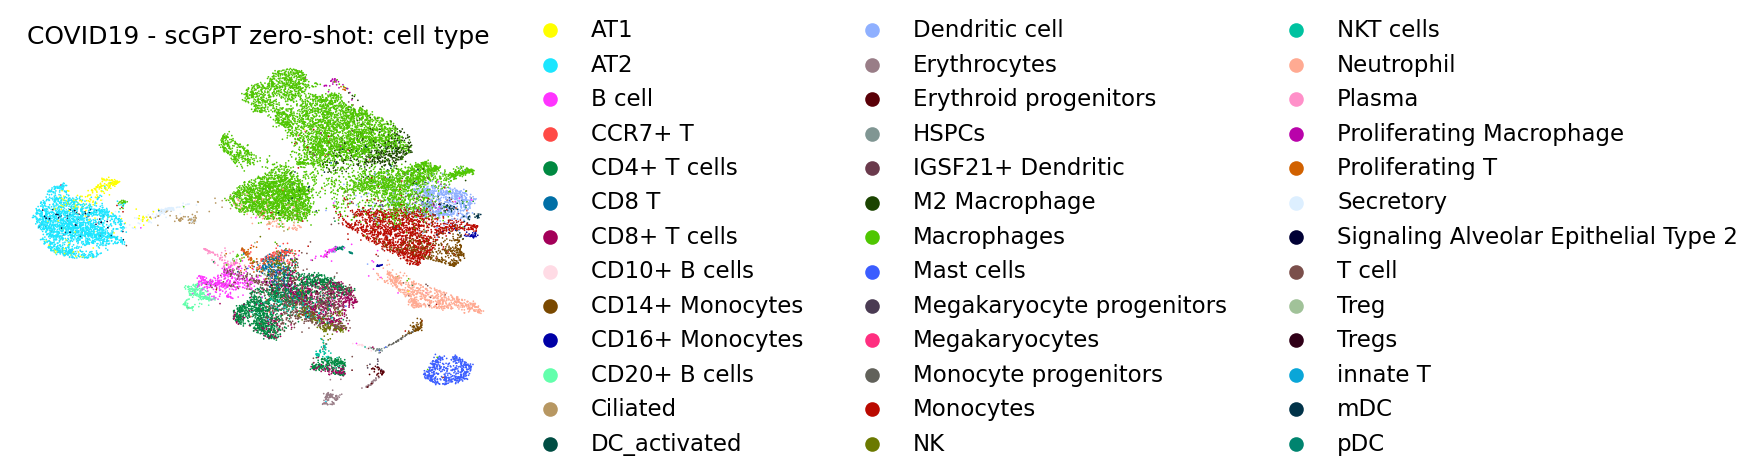

In [18]:
sc.pp.neighbors(embed_adata, use_rep="X_scGPT")
sc.tl.umap(embed_adata)
sc.pl.umap(embed_adata,
           color=[cell_type_key],
           frameon=False,
           title=["COVID19 - scGPT zero-shot: cell type"])

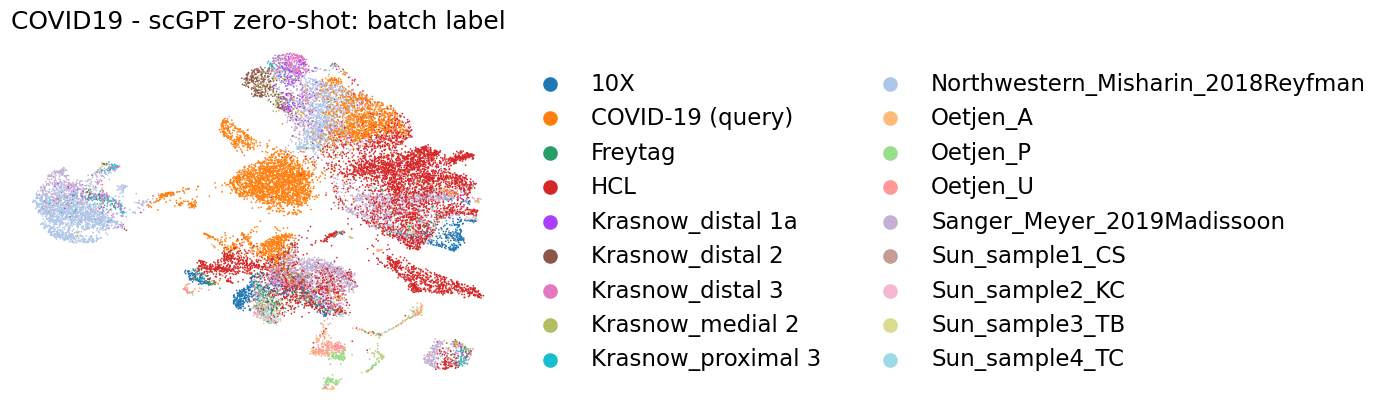

In [19]:
sc.pl.umap(embed_adata,
           color=[batch_key],
           frameon=False,
           title=["COVID19 - scGPT zero-shot: batch label"])

In [20]:
scib_result_dict = scib_eval(
    embed_adata,
    batch_key=batch_key,
    cell_type_key=cell_type_key,
    embed_key="X_scGPT",
)
print("AvgBIO: {:.4f}".format(scib_result_dict["avg_bio"]))
print("AvgBATCH: {:.4f}".format(scib_result_dict["avg_batch"]))

/usr/local/lib/python3.10/dist-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Variance contribution increased after integration!
Setting PCR comparison score to 0.
Graph connectivity...


/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.1

AvgBIO: 0.4824
AvgBATCH: 0.8758


/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)


## Comparison with HVG+PCs

In [21]:
sc.pp.pca(adata, n_comps=40)
sc.pp.neighbors(adata, use_rep="X_pca")

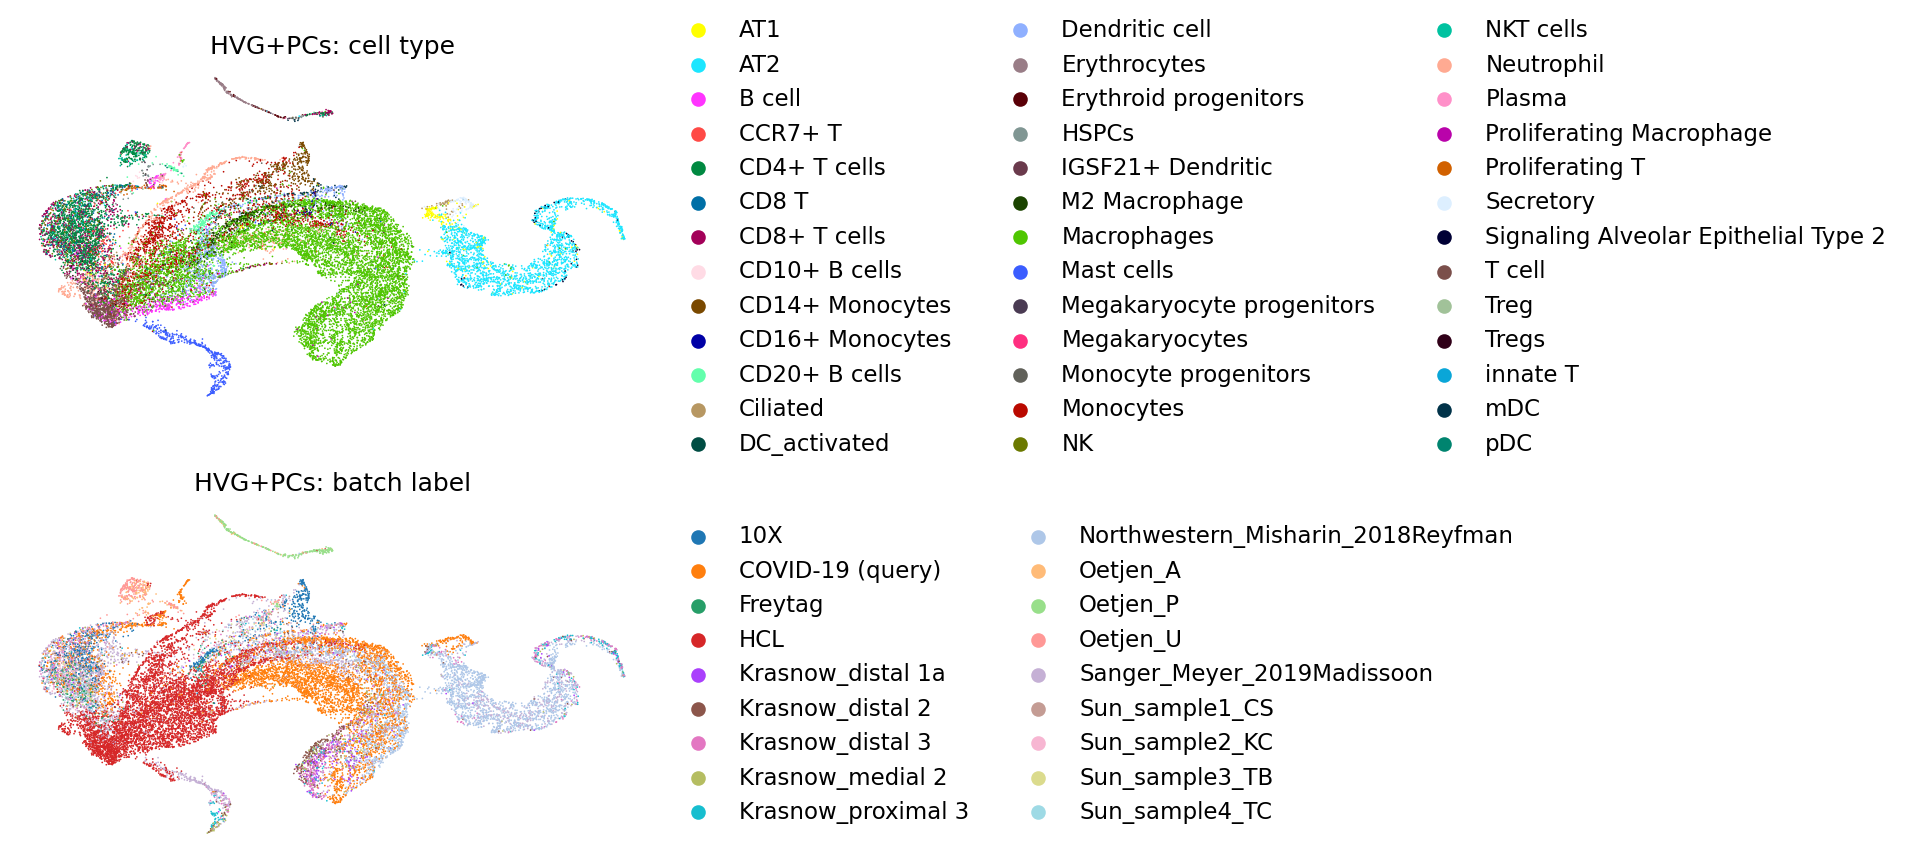

In [22]:
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color=[cell_type_key, batch_key],
    frameon=False,
    wspace=0.4,
    title=["HVG+PCs: cell type", "HVG+PCs: batch label"],
    ncols=1,
)

In [23]:
scib_result_dict = scib_eval(
    adata,
    batch_key=batch_key,
    cell_type_key=cell_type_key,
    embed_key="X_pca",
)
print("AvgBIO: {:.4f}".format(scib_result_dict["avg_bio"]))
print("AvgBATCH: {:.4f}".format(scib_result_dict["avg_batch"]))

/usr/local/lib/python3.10/dist-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Graph connectivity...


/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.1

AvgBIO: 0.3579
AvgBATCH: 0.6710


/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)


### MS dataset

The dataset can be accessed form [here](https://drive.google.com/drive/folders/1Qd42YNabzyr2pWt9xoY4cVMTAxsNBt4v?usp=sharing). As this is a preprocessed dataset, we will need to concatenate the training/test datasets together first.

In [ ]:
gene_col = "gene_name"
cell_type_key = "celltype"
batch_key = "Sample Characteristic[individual]"

train_data = sc.read_h5ad('../../data/ms/c_data.h5ad')
test_data = sc.read_h5ad('../../data/ms/filtered_ms_adata.h5ad')
test_data.var.index = test_data.var[gene_col]
adata = anndata.concat([train_data, test_data], join='outer')
adata.var[gene_col] = adata.var.index

embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)

/h/haotian/.conda/envs/scgpt/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


scGPT - INFO - match 2808/3000 genes in vocabulary of size 60697.


Embedding cells: 100%|██████████| 333/333 [00:12<00:00, 26.59it/s]


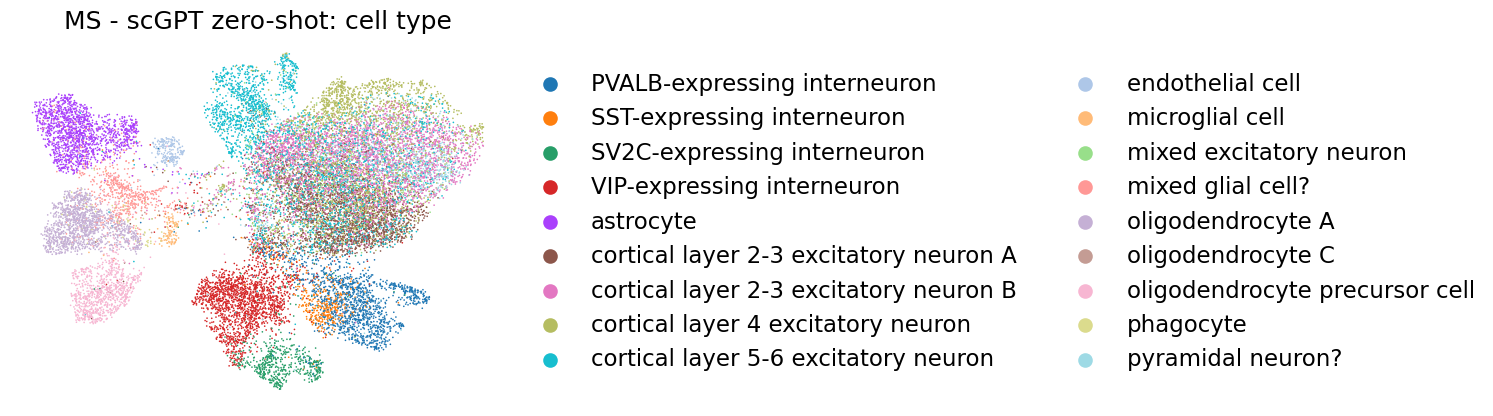

In [ ]:
sc.pp.neighbors(embed_adata, use_rep="X_scGPT")
sc.tl.umap(embed_adata)
sc.pl.umap(embed_adata,
           color=[cell_type_key],
           frameon=False,
           title=["MS - scGPT zero-shot: cell type"])

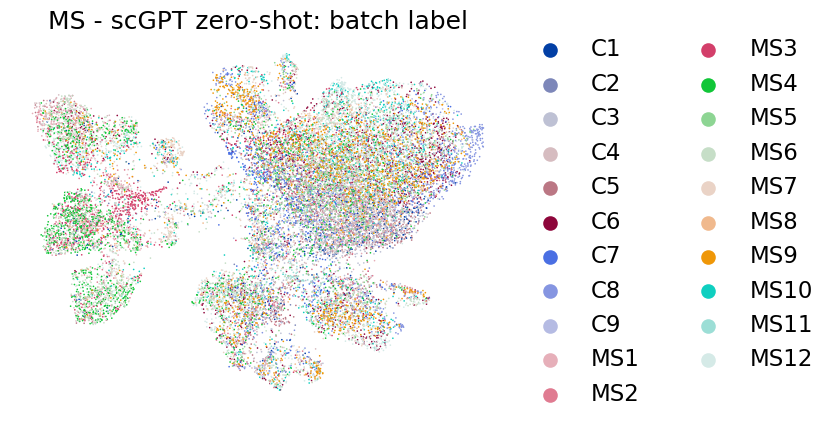

In [ ]:
sc.pp.neighbors(embed_adata, use_rep="X_scGPT")
sc.tl.umap(embed_adata)
sc.pl.umap(embed_adata,
           color=[batch_key],
           frameon=False,
           title=["MS - scGPT zero-shot: batch label"])

In [ ]:
scib_result_dict = scib_eval(
    embed_adata,
    batch_key=batch_key,
    cell_type_key=cell_type_key,
    embed_key="X_scGPT",
)
print("AvgBIO: {:.4f}".format(scib_result_dict["avg_bio"]))
print("AvgBATCH: {:.4f}".format(scib_result_dict["avg_batch"]))

NMI...
ARI...
Silhouette score...
PC regression...
Graph connectivity...
AvgBIO: 0.4525
AvgBATCH: 0.9129


## Comparison with HVG+PCs

In [ ]:
sc.pp.pca(adata, n_comps=40)
sc.pp.neighbors(adata, use_rep="X_pca")

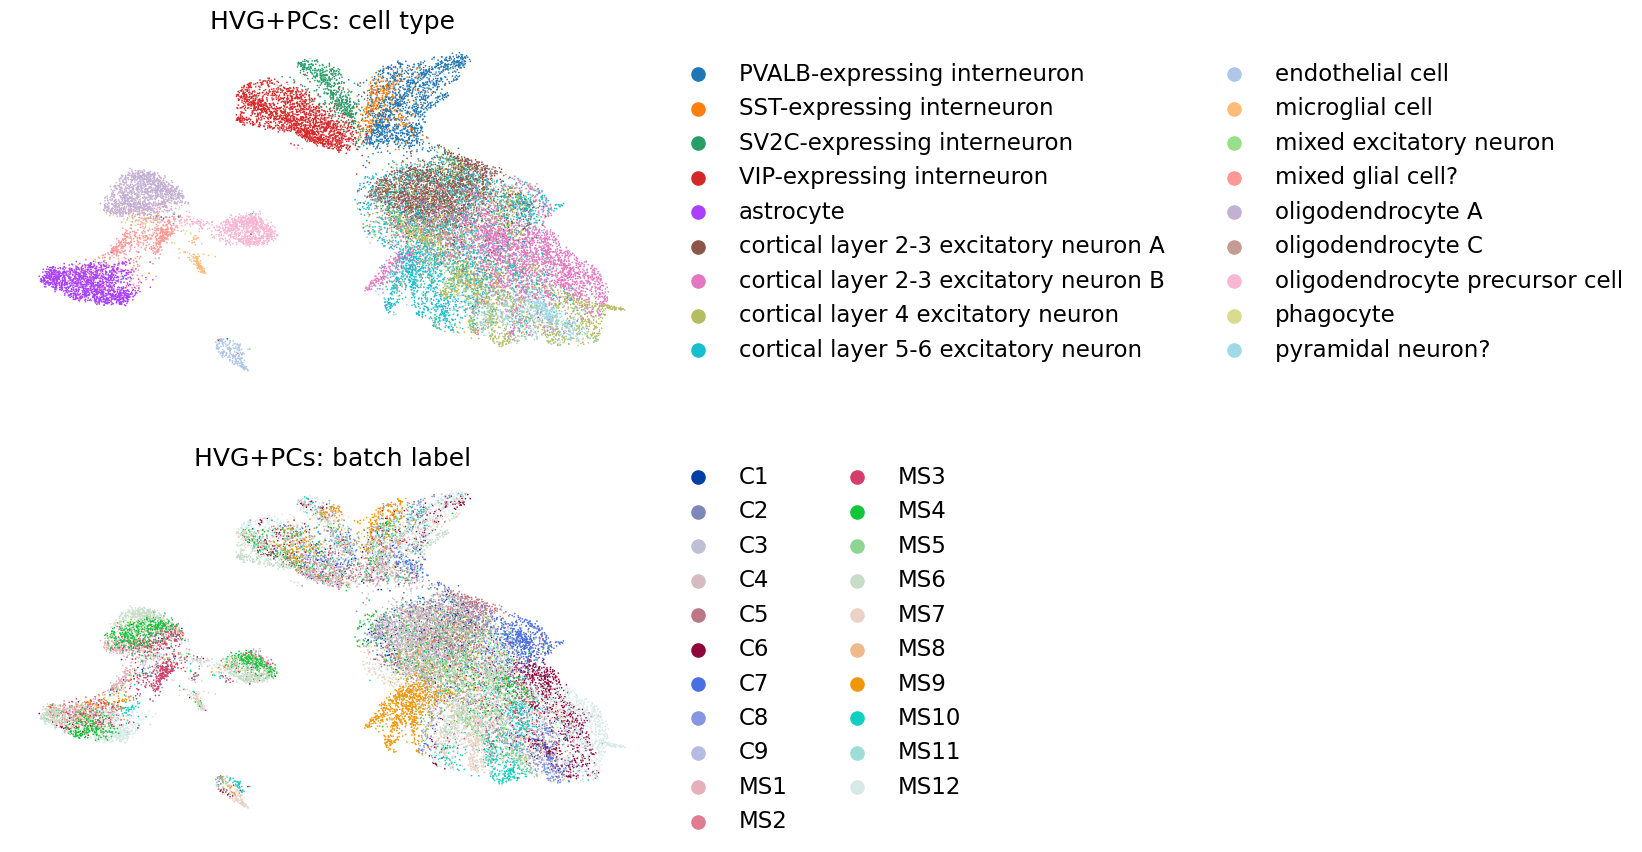

In [ ]:
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color=[cell_type_key, batch_key],
    frameon=False,
    wspace=0.4,
    title=["HVG+PCs: cell type", "HVG+PCs: batch label"],
    ncols=1,
)

In [ ]:
scib_result_dict = scib_eval(
    adata,
    batch_key=batch_key,
    cell_type_key=cell_type_key,
    embed_key="X_pca",
)
print("AvgBIO: {:.4f}".format(scib_result_dict["avg_bio"]))
print("AvgBATCH: {:.4f}".format(scib_result_dict["avg_batch"]))

NMI...
ARI...
Silhouette score...
PC regression...
Graph connectivity...
AvgBIO: 0.5062
AvgBATCH: 0.9075
